In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd

In [56]:
aa = pd.read_csv('/home/seyed/PycharmProjects/dashboard/dashboard/src/dashboard/results/processed_2023-11-19_to_2023-12-31.csv', index_col=0, parse_dates=[0])

In [6]:
data_file_path = [
        "/home/seyed/PycharmProjects/dashboard/dashboard/src/dashboard/results/qq_0.csv",
        "/home/seyed/PycharmProjects/step/STEP/datasets/Brussels/_merged_debug_raw_data_2024-06-03_to_end.csv"
        ]
dfs = []
for file_path in data_file_path:
    df = pd.read_csv(file_path)
    df.index = pd.to_datetime(df.index)
    df.set_index("start_timestamp", inplace=True)
    dfs.append(df)

In [10]:
df = pd.concat(dfs, join="inner")

In [16]:
pd.Series(df.columns).to_pickle

<bound method NDFrame.to_pickle of 0      BXLAND031448F1
1      BXLAND031450F1
2      BXLAND031451F1
3      BXLAND034219F1
4      BXLAND034220F1
            ...      
182    BXLIXL127916F1
183    BXLIXL135836F1
184    BXLIXL138098F1
185    BXLJET031440F1
186    BXLJET031441F1
Length: 187, dtype: object>

In [12]:
pd.Series(df.index).to_pickle("/tmp/dates_index_data_dataset.pkl")


In [13]:
tt = pd.read_pickle("/tmp/dates_index_data_dataset.pkl")

In [18]:
import datetime

In [20]:
datetime.datetime(2024, 6, 11, 0, 35).isoformat()

'2024-06-11T00:35:00'

In [14]:
tt

0        2023-11-19 00:00:00
1        2023-11-19 00:05:00
2        2023-11-19 00:10:00
3        2023-11-19 00:15:00
4        2023-11-19 00:20:00
                ...         
15118    2024-06-12 21:30:00
15119    2024-06-12 21:35:00
15120    2024-06-12 21:40:00
15121    2024-06-12 21:45:00
15122    2024-06-12 21:50:00
Name: start_timestamp, Length: 15123, dtype: object

In [5]:
tt

0            0
1            1
2            2
3            3
4            4
         ...  
15118    15118
15119    15119
15120    15120
15121    15121
15122    15122
Length: 15123, dtype: int64

In [58]:
split_date = '20-12-2023'
pjme_train = aa.loc[aa.index <= split_date].copy()
pjme_test = aa.loc[aa.index > split_date].copy()

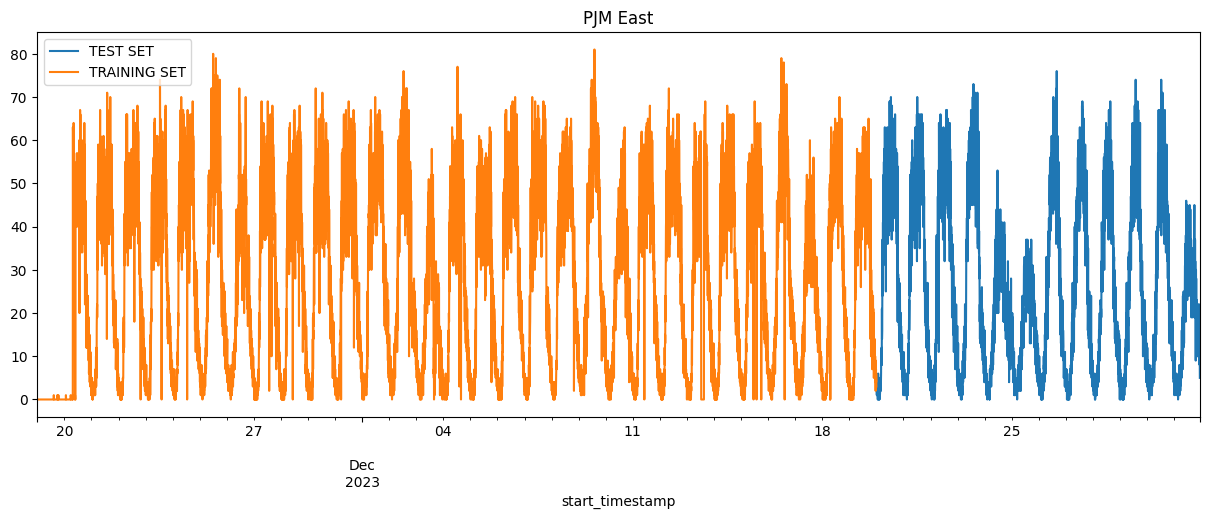

In [59]:
_ = pjme_test[["BXLAND031448F1"]] \
    .rename(columns={'BXLAND031448F1': 'TEST SET'}) \
    .join(pjme_train[["BXLAND031448F1"]].rename(columns={'BXLAND031448F1': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='-')

In [60]:
pjme_test["BXLAND031450F1"]

start_timestamp
2023-12-20 00:05:00    0.0
2023-12-20 00:10:00    1.0
2023-12-20 00:15:00    1.0
2023-12-20 00:20:00    0.0
2023-12-20 00:25:00    1.0
                      ... 
2023-12-31 22:30:00    2.0
2023-12-31 22:35:00    1.0
2023-12-31 22:40:00    1.0
2023-12-31 22:45:00    0.0
2023-12-31 22:50:00    1.0
Name: BXLAND031450F1, Length: 3442, dtype: float64

In [61]:
def create_lag_features(df, lags):
    """
    Create lagged features for a time series.

    Args:
    df (DataFrame): DataFrame containing the time series in a column.
    lags (int): Number of lagged features to create.

    Returns:
    DataFrame: Original DataFrame with lagged features added.
    """
    y = df.copy()
    for column in df.columns:
        x_cols = []
        for lag in range(1, lags + 1):
            x_cols.append(f'lag_{lag}_{column}')
            df[f'lag_{lag}_{column}'] = df[column].shift(lag)
        yield column, df[x_cols], y[column]

In [75]:
x_tr, y_tr, sensor = None, None, None
for sensor, x, y in create_lag_features(pjme_train, 3):
    print(sensor)
    if sensor == 'BXLAND031450F1':
        x_tr, y_tr = x, y
        break

BXLAND031448F1
BXLAND031450F1


In [76]:
y_tr = y_tr.to_frame()

In [77]:
x_test, y_test, sensor = None, None, None
for sensor, x, y in create_lag_features(pjme_test, 3):
    print(sensor)
    if sensor == 'BXLAND031450F1':
        x_test, y_test = x, y
        break

BXLAND031448F1
BXLAND031450F1


In [78]:
y_test = y_test.to_frame()

In [ ]:
x_tr, y_tr = aa.values, aa.values
dtrain = xgb.DMatrix(x_tr, label=y_tr)
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'  # You can change this based on your needs
}
num_boost_round = 100

            # Train the model
bst = xgb.train(params, dtrain, num_boost_round)

In [79]:
x_tr.columns , x_test.columns

(Index(['lag_1_BXLAND031450F1', 'lag_2_BXLAND031450F1', 'lag_3_BXLAND031450F1'], dtype='object'),
 Index(['lag_1_BXLAND031450F1', 'lag_2_BXLAND031450F1', 'lag_3_BXLAND031450F1'], dtype='object'))

In [80]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_tr, y_tr,
        eval_set=[(x_tr, y_tr), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
from xgboost import plot_importance

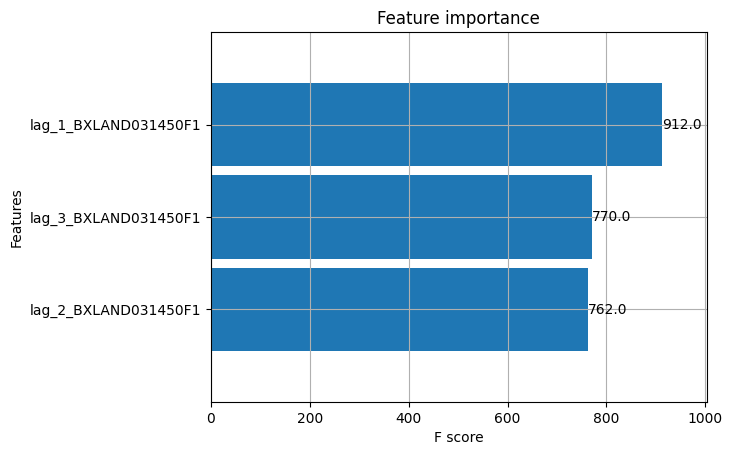

In [82]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)



In [83]:
y_test[f'BXLAND031450F1_Prediction'] = reg.predict(x_test)
# pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

<Axes: xlabel='start_timestamp'>

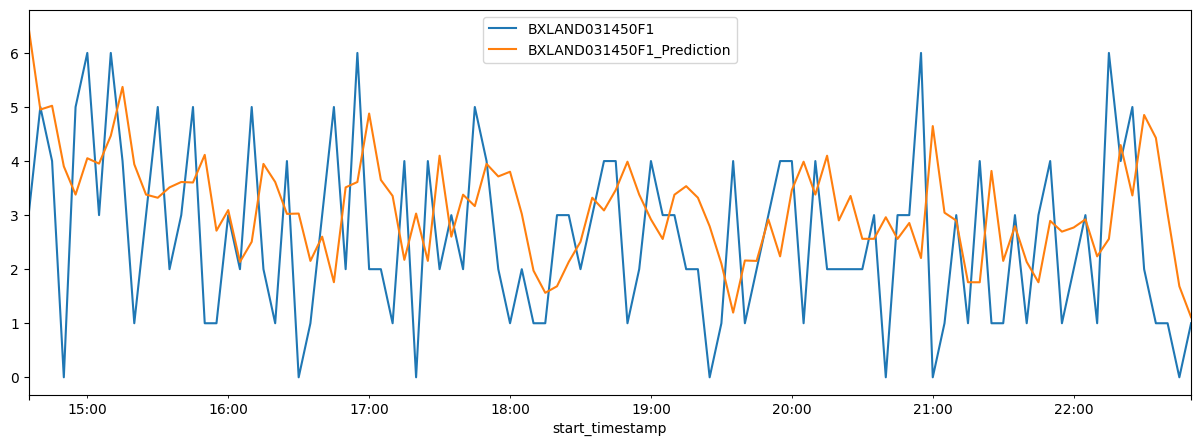

In [85]:
y_test.iloc[-100:,:].plot(figsize=(15, 5))

In [92]:
for key in reg.evals_result():
    print(np.mean(reg.evals_result()[key]["rmse"]), reg.evals_result()[key].keys())

3.2306064294985064 odict_keys(['rmse'])
3.4848424614907993 odict_keys(['rmse'])
